### 推論結果の評価
- Google Colaboratoryにて実行
- 混同行列にてファインチューニングした結果を可視化

In [1]:
# ライブラリインストール
!pip install transformers
!pip install torch
!pip install accelerate -U
!pip install datasets
!pip install fugashi
!pip install ipadic


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 600.9/600.9 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 64.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ipadic: filename=ipadic-1.0.0-py3-none-any.whl size=13556704 sha256=a3b435732d363506f9fc9716c706ec0ccebef45282f436e9a43d04b25db8f2a2
  Stored in directory: /root/.cache/pip/wheels/5b/ea/e3/2f6e0860a327daba3b030853fce4483ed37468bbf1101c59c3
Successfully built ipadic


In [2]:
# import
import os
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import torch
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt


In [3]:
# 評価データ
dataset = load_dataset("tyqiangz/multilingual-sentiments", "japanese")

# フォーマットを指定し、データフレームとして読み込む
dataset.set_format(type="pandas")
train_df = dataset["train"][:]
validation_df = dataset["validation"][:]
test_df = dataset["test"][:]

# source列とlabel列の値の内訳を確認
print(f'train_df.value_counts(["source", "label"]):\n{train_df.value_counts(["source", "label"])}')
print(f'validation_df.value_counts(["source", "label"]):\n{validation_df.value_counts(["source", "label"])}')
print(f'test_df.value_counts(["source", "label"]):\n{test_df.value_counts(["source", "label"])}')

# テーブル構造を確認
print(f'train:\n{dataset["train"].features}')
print(f'validation:\n{dataset["validation"].features}')
print(f'test:\n{dataset["test"].features}')


Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

----------------------------------------------------------------------------------------------------
                                                text     label  \
0  普段使いとバイクに乗るときのブーツ兼用として購入しました。見た目や履き心地は良いです。 しか...  negative   
1  十分な在庫を用意できない販売元も悪いですが、Amazonやら楽⚪︎が転売を認めちゃってるのが...  negative   
2  見た目はかなりおしゃれで気に入りました。2、3回持ち歩いた後いつも通りゼンマイを巻いていたら...  negative   
3  よくある部分での断線はしませんでした ただiphoneとの接続部で接触不良、折れました ip...  negative   
4  プラモデルの塗装剥離に使う為に購入 届いて早速使ってみた 結果 １ヶ月経っても未だに剥離出来...  negative   

                 source  
0  amazon_reviews_multi  
1  amazon_reviews_multi  
2  amazon_reviews_multi  
3  amazon_reviews_multi  
4  amazon_reviews_multi  
----------------------------------------------------------------------------------------------------


Generating validation split:   0%|          | 0/3000 [00:00<?, ? examples/s]

----------------------------------------------------------------------------------------------------
                                                text     label  \
0  味自体及び吸い心地は良いのだが、不良品が多過ぎる。私の場合５本のうち２本が蒸気も出ず、吸い込...  negative   
1             ホームボタン周りの気泡が全く抜けません。 返金をお願いしましたが、断られた。  negative   
2  新旧含めて4つのカーテンレールがあるのですが、使用出来るカーテンレールはありませんでした。 ...  negative   
3            予約注文でしたが、どこから特典であるpdfダウンロードすればよいのでしょうか…  negative   
4  前のレビューにもありましたが、片方が全く動きません。 返品しようにも、なんだかめんどくさいし...  negative   

                 source  
0  amazon_reviews_multi  
1  amazon_reviews_multi  
2  amazon_reviews_multi  
3  amazon_reviews_multi  
4  amazon_reviews_multi  
----------------------------------------------------------------------------------------------------


Generating test split:   0%|          | 0/3000 [00:00<?, ? examples/s]

----------------------------------------------------------------------------------------------------
                                                text     label  \
0  購入、貼付け後2週間もたたないうちに、上側から剥がれてきて画面から浮いた状態になってしまった...  negative   
1  以下の3点の理由により、期待はずれの粗悪品。 ①他の方のレビューにもある通り、天板の外観が掲...  negative   
2  この商品の内容等確認した購入したのですが、そのとおりなかなか設定ができなく、知人にもお願いし...  negative   
3  テストした結果、4000mahのスマホ一回と30％分、スマホのバッテリー残量の表示が正しけれ...  negative   
4  前回の黒いドレッサーバッグの評判がよかったため、予約して購入しました。 ガッカリです。 ヨレ...  negative   

                 source  
0  amazon_reviews_multi  
1  amazon_reviews_multi  
2  amazon_reviews_multi  
3  amazon_reviews_multi  
4  amazon_reviews_multi  
----------------------------------------------------------------------------------------------------
train_df.value_counts(["source", "label"]):
source                label
amazon_reviews_multi  0        40000
                      1        40000
                      2        40000
dtype: int64
validation_df.value_counts(["source", "label"]):


In [4]:
def label_int2str(x, dataset_name):
    """
    整数ラベルを文字列ラベルに変換する関数
    Args:
        x (int): 変換する整数ラベル
        dataset_name (str): データセット名
    Returns:
        str: 文字列ラベル
    変数datasetが宣言済みの部分で実行しないとエラーになる。
    """
    return dataset[dataset_name].features["label"].int2str(x)

# validation_df, test_dfの"label_name"列は後半で使用する
train_df["label_name"] = train_df["label"].apply(label_int2str, dataset_name="train")
validation_df["label_name"] = validation_df["label"].apply(label_int2str, dataset_name="validation")
test_df["label_name"] = test_df["label"].apply(label_int2str, dataset_name="test")

# データフレームにしていたフォーマットをデフォルトに戻す
dataset.reset_format()


データセットのトークン化

In [5]:
# トークン化に使うモデル（ファインチューニング無しモデルの推論でも使用）
model_name = "cl-tohoku/bert-base-japanese-whole-word-masking"
tokenizer = AutoTokenizer.from_pretrained(model_name)


tokenizer_config.json:   0%|          | 0.00/110 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/258k [00:00<?, ?B/s]

In [6]:
def tokenize(batch):
    """
    データセットのトークン化
    Args:
        batch (_type_): _description_
    Returns:
        _type_: _description_
    """
    return tokenizer(
        batch["text"],
        padding=True, # バッチ内の最も長い系列長に合うようpaddingする処理を有効化
        truncation=True # 後段のモデルが対応する最大コンテキストサイズ以上を切り捨て
    )

# データセット全体
dataset_encoded = dataset.map(
    tokenize,
    batched=True, # バッチ化
    batch_size=None # 全体が1バッチとなる
)

# 結果の確認
dataset_encoded


Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'source', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 120000
    })
    validation: Dataset({
        features: ['text', 'source', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3000
    })
    test: Dataset({
        features: ['text', 'source', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3000
    })
})

### 推論

In [7]:
def predict_sentiments_by_loaded_model(
    text_list,
    model_path,
  ):
  """
  リストを読み込み推論を行う
  """

  # デバイス設定
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  # トークナイザ・モデル読み込み
  tokenizer = AutoTokenizer.from_pretrained(model_path)
  model = AutoModelForSequenceClassification.from_pretrained(model_path).to(device)

  # テキストデータの推論
  sentiment_list = []
  positive_score_list = []
  neutral_score_list = []
  negative_score_list = []

  for text in text_list:
    inputs = tokenizer(text, truncation=True, padding=True, return_tensors= 'pt')

    model.eval()

    with torch.no_grad():
      outputs = model(
          inputs["input_ids"].to(device),
          inputs["attention_mask"].to(device),
      )
    # print(f"outputs.logits: {outputs.logits}")

    # logitsを確率に変換
    probabilities = F.softmax(outputs.logits, dim=1)[0].cpu().numpy().tolist()
    probabilities = [round(prob, 5) for prob in probabilities]
    # 各分類の確率をリストに格納
    positive_score_list.append(probabilities[0])
    neutral_score_list.append(probabilities[1])
    negative_score_list.append(probabilities[2])

    # logitsを推論ラベルに変換・リストへ格納
    pred_id = np.argmax(outputs.logits.to('cpu').detach(), axis=1).tolist()[0]
    # print(pred_id)
    pred_label = model.config.id2label[pred_id]
    sentiment_list.append(pred_label)

  df_sentiments = pd.DataFrame(
    data = {
        'text': text_list,
        'sentiment': sentiment_list,
        'score_positive': positive_score_list,
        'score_neutral': neutral_score_list,
        'score_negative': negative_score_list
    }
  )

  return df_sentiments

# ディレクトリ・ファイル名・設定など（学習済みモデル）
loading_dir = "/content/drive/MyDrive/Colab Notebooks/NLP/text_classification/"
model_path = "text-classification-bert_fine-tuned/"

# 推論
df_sentiment_val_1 = predict_sentiments_by_loaded_model(
    text_list = dataset_encoded["validation"]["text"],
    model_path = loading_dir + model_path,
)
df_sentiment_test_1 = predict_sentiments_by_loaded_model(
    text_list = dataset_encoded["test"]["text"],
    model_path = loading_dir + model_path,
)


In [8]:
# 解答ラベルをデータフレームに追加
df_sentiment_val_1["sentiment_answer"] = validation_df["label_name"].to_list()
df_sentiment_test_1["sentiment_answer"] = test_df["label_name"].to_list()

# データフレーム保存
evaluation_dir = loading_dir + "prediction_data/output/evaluation/fine-tuned_model/"
os.makedirs(evaluation_dir, exist_ok = True)
df_sentiment_val_1.to_csv(evaluation_dir + "df_validation.csv", encoding = "utf-8_sig")
df_sentiment_test_1.to_csv(evaluation_dir + "df_test.csv", encoding = "utf-8_sig")
df_sentiment_val_1


,text,sentiment,score_positive,score_neutral,score_negative,sentiment_answer
0,味自体及び吸い心地は良いのだが、不良品が多過ぎる。私の場合５本のうち２本が蒸気も出ず、吸い込...,negative,0.00034,0.00291,0.99674,negative
1,ホームボタン周りの気泡が全く抜けません。 返金をお願いしましたが、断られた。,negative,0.00018,0.00482,0.99500,negative
2,新旧含めて4つのカーテンレールがあるのですが、使用出来るカーテンレールはありませんでした。 ...,negative,0.00196,0.25098,0.74706,negative
3,予約注文でしたが、どこから特典であるpdfダウンロードすればよいのでしょうか…,neutral,0.04844,0.80801,0.14355,negative
4,前のレビューにもありましたが、片方が全く動きません。 返品しようにも、なんだかめんどくさいし...,negative,0.00020,0.00239,0.99741,negative
...,...,...,...,...,...,...
2995,ミニオンが好きで、息子に買いました。 親子で楽しく遊んでます。,positive,0.95168,0.04592,0.00240,positive
2996,まずレーザーの光が強いw 昔 ゲーセンで取ったヤツの3倍くらい 暗闇でレーザーの光が当たった...,positive,0.95719,0.03846,0.00434,positive
2997,"色もち、発色もよく、ティントによくある""激しい唇の荒れ""が少ないのでとても使いやすいなと思い...",positive,0.99676,0.00260,0.00064,positive
2998,1年前に別メーカーのバッテリーを交換して、使えましたが、スマホ確認のところで認識さらませんで...,positive,0.99660,0.00224,0.00116,positive


### 混同行列による推論結果の可視化（ファインチューニングモデル）
- 検証データ、テストデータでの混同行列を算出して可視化

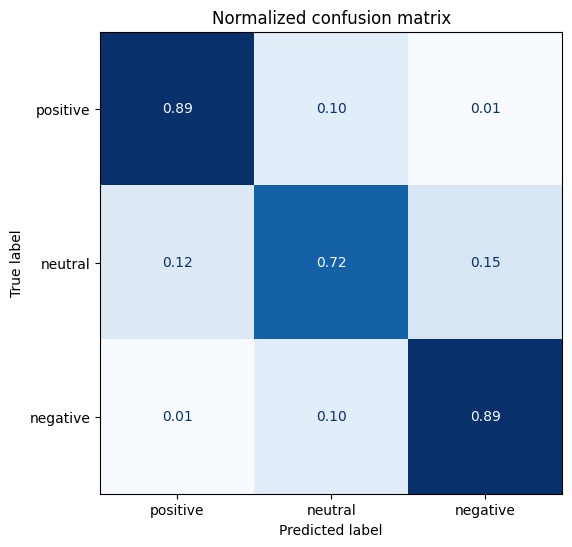

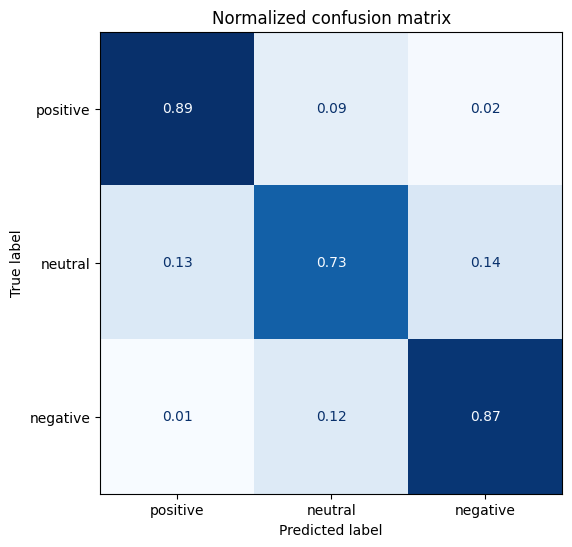

In [9]:
# 検証データの推論結果を混同行列で可視化
pred_col = "sentiment"
str2int_dict = {'positive': 0, 'neutral': 1, 'negative': 2}
y_preds_valid_1 = df_sentiment_val_1[pred_col].map(str2int_dict).to_numpy()
y_preds_test_1 = df_sentiment_test_1[pred_col].map(str2int_dict).to_numpy()
y_valid = np.array(dataset_encoded["validation"]["label"])
y_test = np.array(dataset_encoded["test"]["label"])
labels = dataset_encoded["train"].features["label"].names

def plot_confusion_matrix(y_preds, y_true, labels, saving_path):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.savefig(saving_path)
    plt.show()

plot_confusion_matrix(y_preds_valid_1, y_valid, labels, evaluation_dir + "confusion_matrix_val_predicted_by_fine-tuned_model.png")
plot_confusion_matrix(y_preds_test_1, y_test, labels, evaluation_dir + "confusion_matrix_test_predicted_by_fine-tuned_model.png")
